In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Leitura dos datasets e rótulos

In [105]:
df = pd.read_csv('../testbed/data/malicious_dataset.csv') # dataset malicioso
attack_classes = pd.read_csv("attack_labels_sbseg.csv") # rótulos dos ataques por ip_src
normal = pd.read_csv('../mawilab/data/normal_dataset.csv') # dataset normal

### Rótulos de ataques

In [106]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn', 'nmap_vvv', 'nmap_fast', 'nmap_top10'],
      dtype=object)

### Criação do dataset malicioso com os rótulos definidos pelo *ip_src*

In [107]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,ip.id,ip.flags,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Dec 31, 1969 21:03:41.953641000 -03",221.953641,20,58,58,0x00000800,4,20,NaN,0x0000b2c5,0x00000000,0,0,0,0,46,6,0x000019e0,172.16.0.3,10.10.10.10,44,0x00000000,62218,8888,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00005cb1,0,1460.0,nmap_tcp_syn
1,1,"Dec 31, 1969 21:03:41.953762000 -03",221.953762,21,58,58,0x00000800,4,20,NaN,0x0000d3a4,0x00000000,0,0,0,0,37,6,0x00000201,172.16.0.3,10.10.10.10,44,0x00000000,62218,587,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00007d1e,0,1460.0,nmap_tcp_syn


In [108]:
normal['label'] = "normal" # criação da coluna label no dataset normal com rótulo "normal"

## Comparação dataset _normal_ e _malicioso_
> Verifica se os dois datasets possuem as mesmas colunas/atributos e calcula o % de dados legítimos e maliciosos

In [109]:
if (df_labeled.columns == normal.columns).all():
    examples_malicious = df_labeled.shape[0]
    examples_legitim = normal.shape[0]
    total = examples_malicious+examples_legitim
    print('Total examples of {0} with {1:0.2f} of malicious and {2:0.2f} legitim packets'.format(total, examples_malicious/total, examples_legitim/total))

Total examples of 127701 with 0.19 of malicious and 0.81 legitim packets


## Pré-processamento
> Necessário conversão dos atributos que são extraídos do `pcap` como hexadecimal
> Preenchido os campos que possuem valores nulos (NaN) por zero

In [110]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))
    

In [111]:
normal = normal.fillna(0)
for field in fields:
    normal[field] = normal[field].apply(lambda x: int(str(x), 16))

### Criação do dataset com todos os pacotes normais e maliciosos

In [112]:
full_data = pd.concat([normal, df_labeled])

### Checando se há pacotes com o campo de protocolo diferente de TCP (valor 6)

In [113]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("Foram encontrados e removidos", wrong_proto,"pacotes do dataset original.")

Foram encontrados e removidos [11708] pacotes do dataset original.


### Atributos não aplicáveis nesse trabalho

> Remoção dos atributos da camada de enlace (link) - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remoção de atributos redudantes ou invariáveis
> - ip.version - trata-se de IPv4
> - ip.proto - o escopo do trabalho restringe-se a TCP
> - ip.src
> - ip.dst
> - ip.flags
> - tcp.flags - utiliza-se as flags separadamente

In [114]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'ip.flags', 'tcp.flags'], axis=1, inplace=True)

## Análise Exploratória dos Dados

In [115]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115993 entries, 1 to 24606
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           115993 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                115993 non-null  int64  
 3   ip.flags.rb          115993 non-null  float64
 4   ip.flags.df          115993 non-null  float64
 5   ip.flags.mf          115993 non-null  float64
 6   ip.frag_offset       115993 non-null  float64
 7   ip.ttl               115993 non-null  float64
 8   ip.checksum          115993 non-null  int64  
 9   ip.len               115993 non-null  float64
 10  ip.dsfield           115993 non-null  int64  
 11  tcp.srcport          115993 non-null  float64
 12  tcp.dstport          115993 non-null  float64
 13  tcp.seq              115993 non-null  float64
 14  tcp.ack              115993 non-null  float64
 15  tcp.len           

In [116]:
full_data.describe()

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.checksum,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val
count,115993.0,91386.0,115993.000000,115993.0,115993.000000,115993.0,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,1.159930e+05,1.159930e+05,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,115993.000000,1.159930e+05,115993.000000,115993.000000,102708.000000
mean,20.0,0.0,31382.061831,0.0,0.606459,0.0,0.019208,124.369962,32196.366608,618.286457,2.206340,25874.960661,28389.081384,3.935127e+07,4.013616e+07,571.080505,27.359617,0.075651,0.321933,0.022027,0.092859,0.607157,0.034735,0.009423,8.657366e+03,32333.421008,0.751666,226.250127
std,0.0,0.0,19683.750111,0.0,0.488537,0.0,0.195058,87.287815,19036.915237,688.925293,8.098296,24993.610197,24817.317433,1.103669e+08,2.416238e+08,686.730468,7.600707,0.264440,0.467220,0.146773,0.290236,0.488384,0.183108,0.096614,7.875116e+04,18951.463687,180.831415,539.018184
min,20.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,1.000000,24.000000,0.000000,21.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,20.0,0.0,14012.000000,0.0,0.000000,0.0,0.000000,59.000000,15277.000000,40.000000,0.000000,443.000000,993.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.350000e+02,16108.000000,0.000000,0.000000
50%,20.0,0.0,31097.000000,0.0,1.000000,0.0,0.000000,62.000000,31864.000000,64.000000,0.000000,24858.000000,35008.000000,1.000000e+00,1.000000e+00,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.023000e+03,32093.000000,0.000000,0.000000
75%,20.0,0.0,48865.000000,0.0,1.000000,0.0,0.000000,242.000000,48737.000000,1426.000000,0.000000,51345.000000,51287.000000,1.248557e+07,3.714000e+03,1374.000000,32.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.200000e+03,48356.000000,0.000000,0.000000
max,20.0,0.0,65535.000000,0.0,1.000000,0.0,2.000000,254.000000,65534.000000,5981.000000,224.000000,65534.000000,65535.000000,4.294967e+09,4.294967e+09,5941.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.644544e+07,65533.000000,46335.000000,8961.000000


In [117]:
# checar atributos com variância zero, não contribuem com aprendizado
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset         False
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

In [118]:
# remove colunas com variância zero
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Análise univariada dos atributos (boxplot)

In [119]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

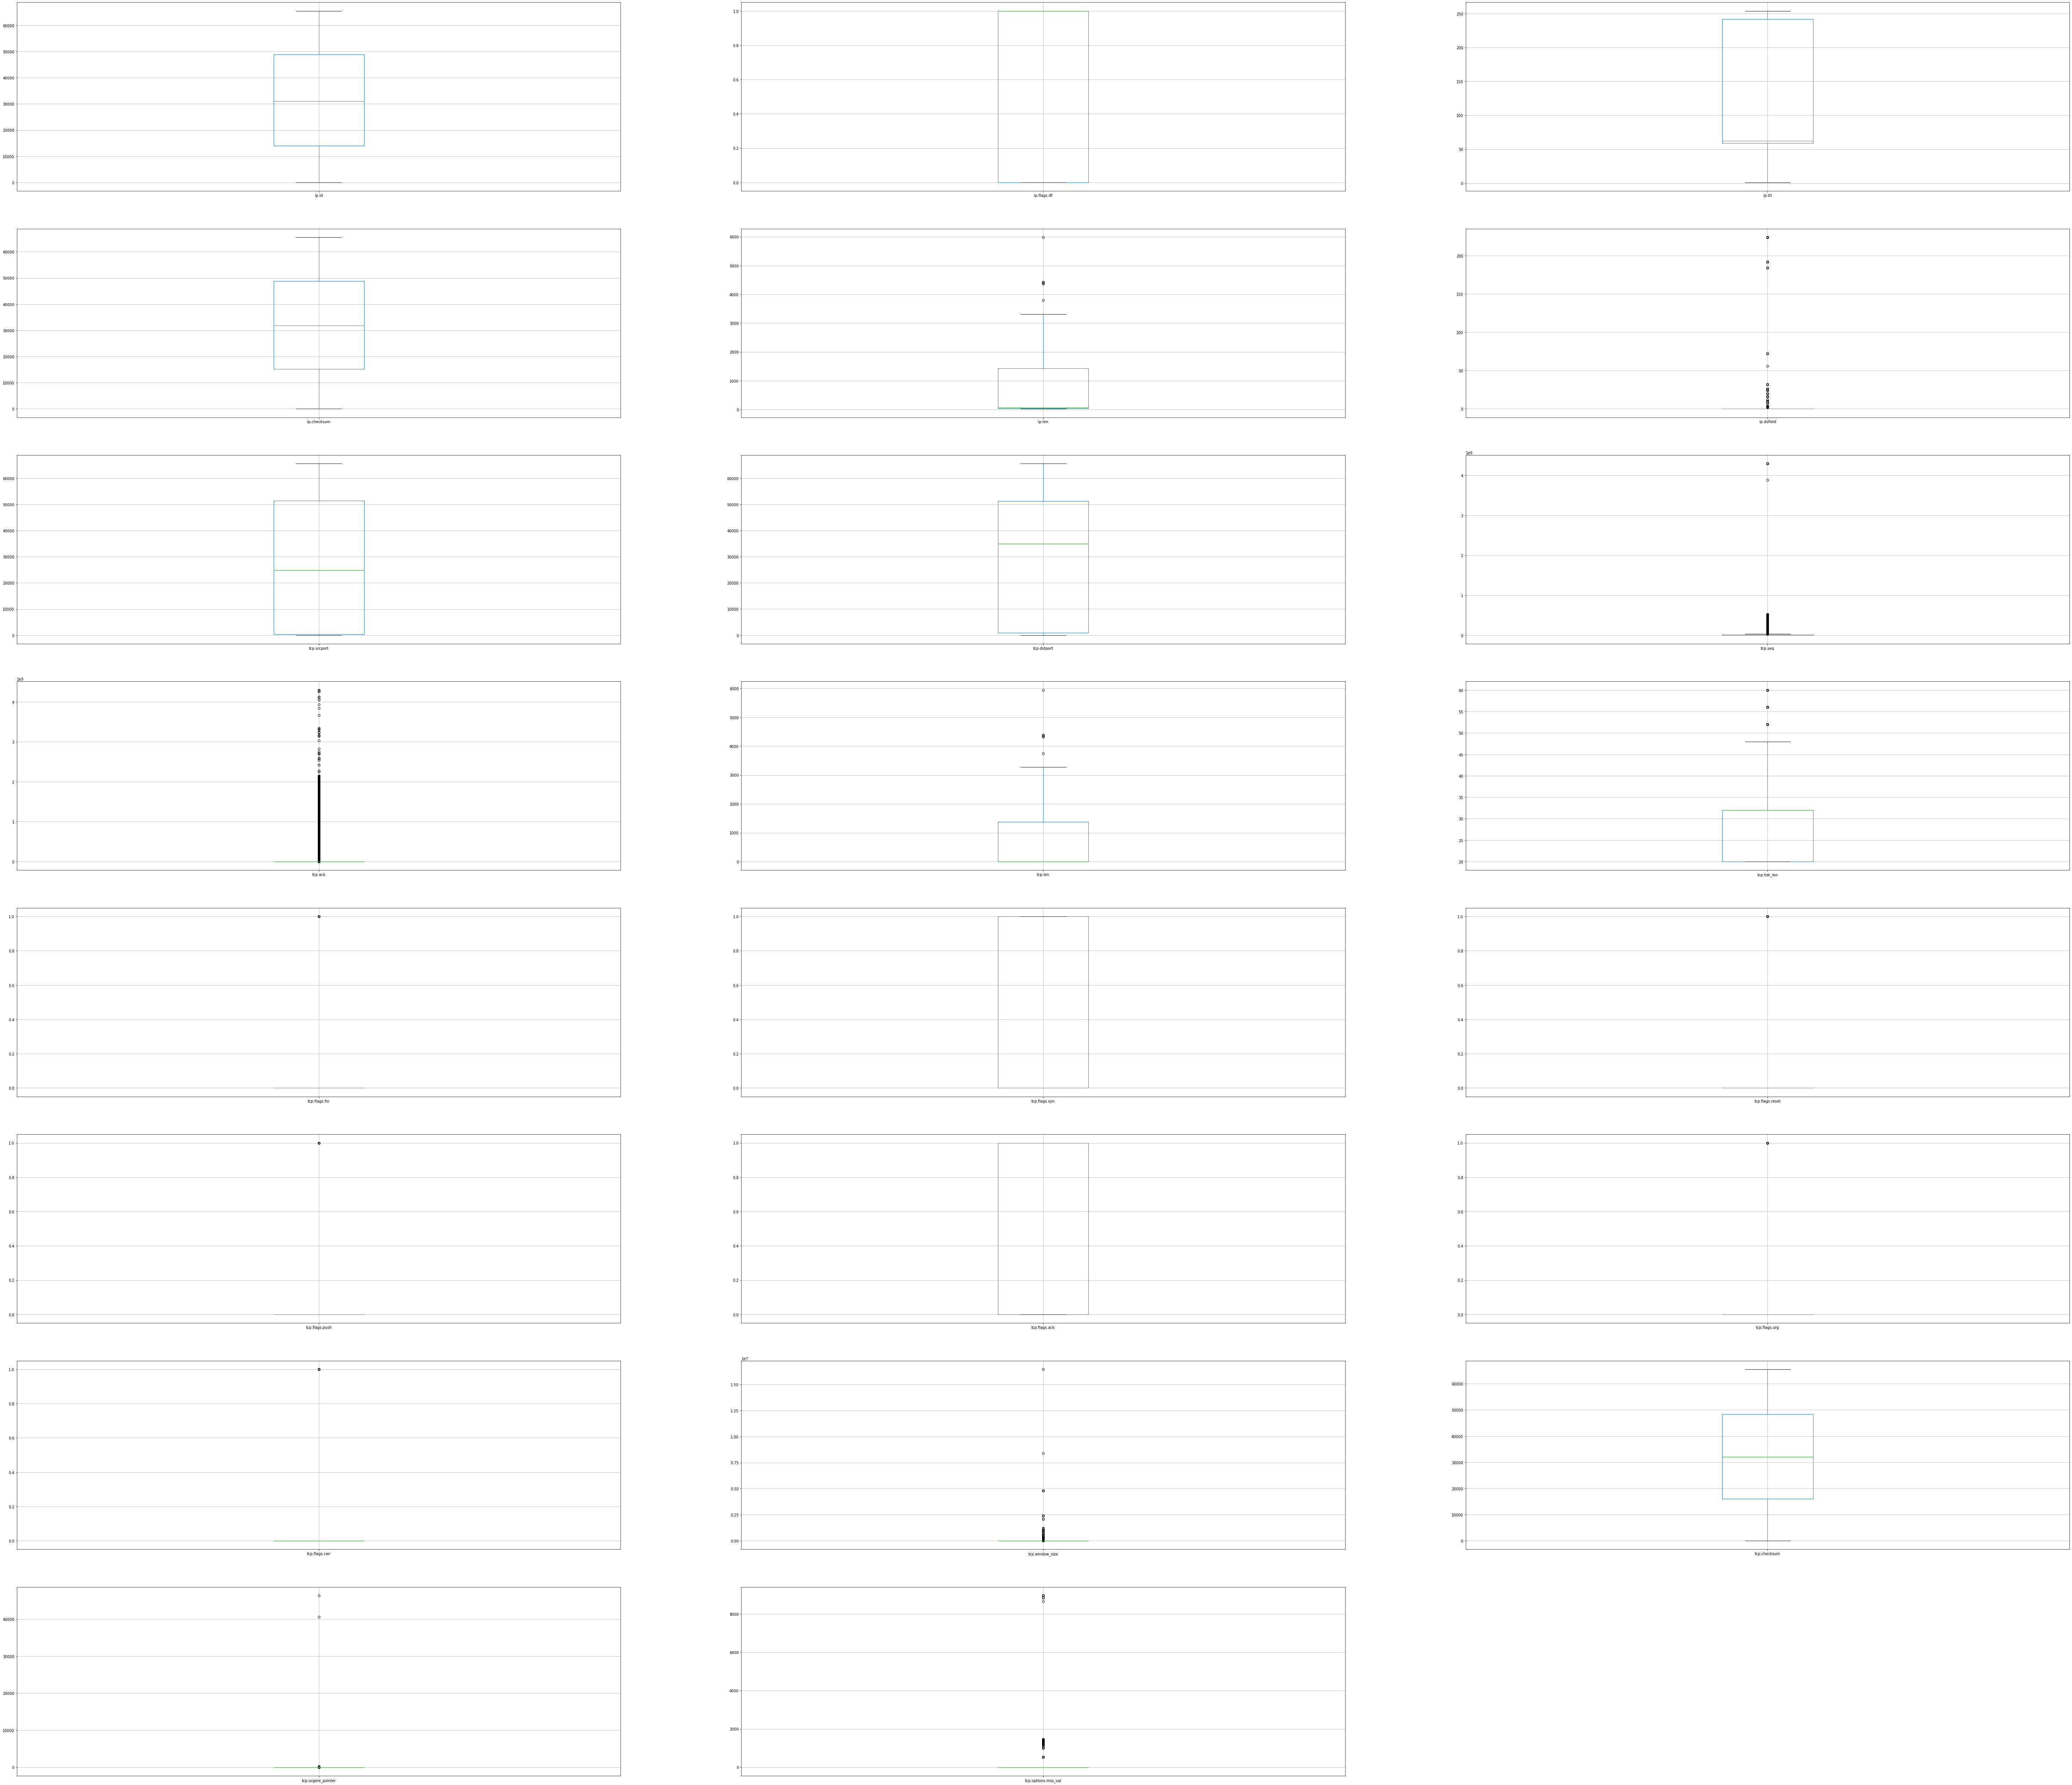

In [120]:
colunas = 3
linhas = int(full_data.shape[1]/colunas)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(linhas, colunas, i)
        full_data.boxplot([column]);
        i += 1

### Análise bivariada - Correlação linear (threshold de 0.5)

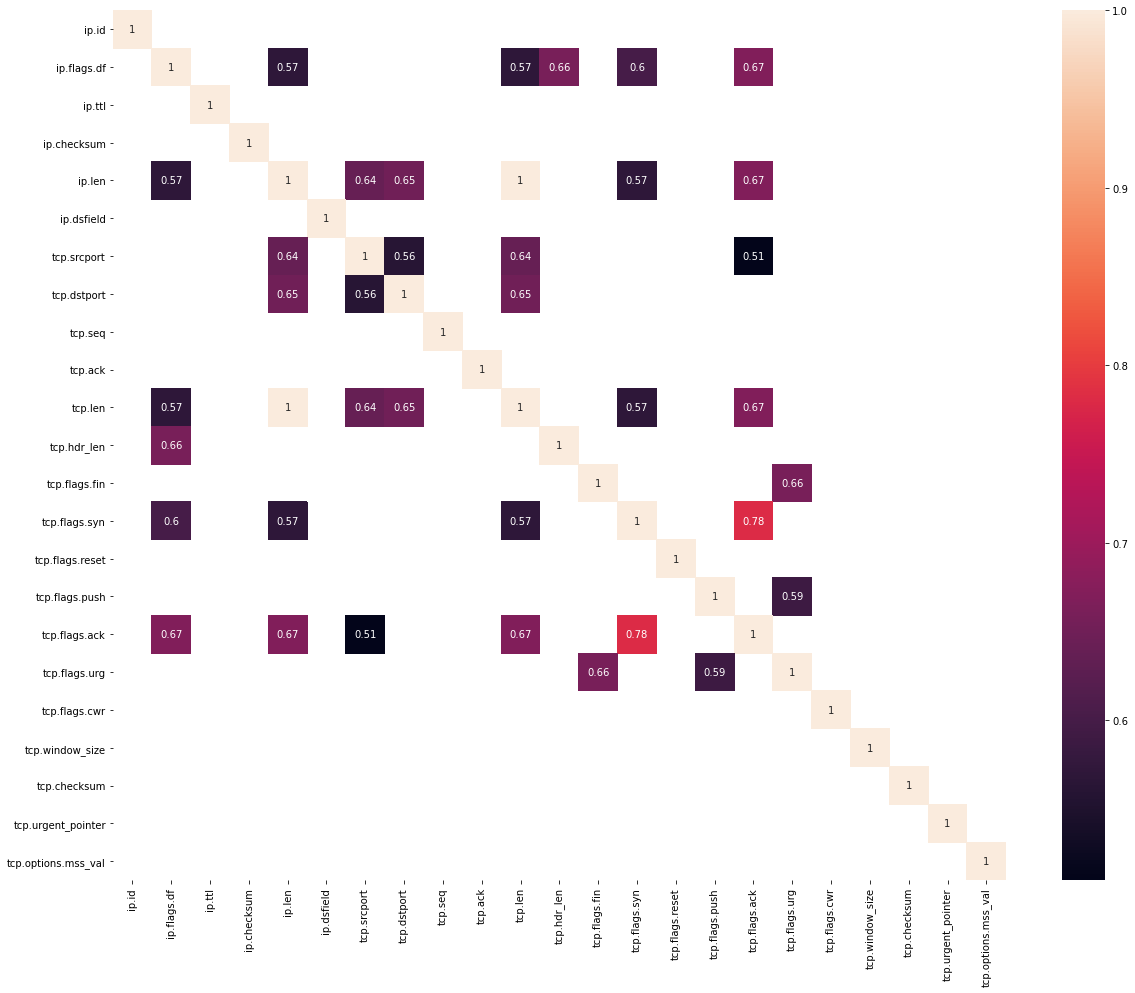

In [121]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Aprendizado de Máquina - Classificação Binária _(scan x normal)_

In [122]:
full_data['label'].value_counts()

normal                   91386
nmap_vvv                  2002
zmap_tcp_syn              1250
unicornscan_tcp_conn      1026
unicornscan_tcp_syn       1017
unicornscan_tcp_fin       1014
unicornscan_tcp_fxmas     1014
unicornscan_tcp_xmas      1014
unicornscan_tcp_ack       1014
unicornscan_tcp_null      1014
masscan_tcp_syn           1003
nmap_tcp_conn             1002
nmap_tcp_syn              1001
hping_tcp_syn             1001
nmap_tcp_xmas             1001
nmap_tcp_null             1001
nmap_tcp_fin              1001
hping_tcp_xmas            1000
hping_tcp_ack             1000
nmap_tcp_maimon           1000
hping_tcp_null            1000
nmap_tcp_window           1000
hping_tcp_fin             1000
nmap_tcp_ack              1000
nmap_fast                  206
nmap_top10                  26
Name: label, dtype: int64

In [123]:
full_data.label[full_data.label == "normal"] = 0 # converte os labels de normal por 0
full_data.label[full_data.label != 0] = 1 # converte os labels de scan por 1
full_data['label'].value_counts()

0    91386
1    24607
Name: label, dtype: int64

In [124]:
full_data.shape

(115993, 24)

In [125]:
# ttl tem refletido a arquitetura de obtenção dos pacotes TTL=62 (originalmente 64 menos 2 roteadores)
full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.srcport",
                        "tcp.ack", "tcp.seq", "tcp.options.mss_val"], axis=1, inplace=True)

In [126]:
full_data

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,label
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24602,17702,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1
24603,16090,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1
24604,32893,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1
24605,28821,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1


In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

algorithms = {
    "NB" : (GaussianNB(), {}),
    "LR" : (LogisticRegression(), {}),
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        "class_weight": (None, "balanced") # , {0:0.02, 1:0.98}
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(115993, 15) (115993,)


## Grid Search para os parâmetros da Árvore de Decisão

In [128]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # pode ser considerado também o roc_auc_score na classificação binária

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

NB
LR
DT


In [129]:
# f1-scores para o melhor conjunto de parâmetros do Grid Search
pd.DataFrame.from_dict(score)

,NB,LR,DT
0,0.571130,0.691137,0.963778
1,0.565747,0.686472,0.966653
2,0.576720,0.692681,0.960064
3,0.576824,0.682891,0.965021
4,0.571827,0.695820,0.966306
5,0.570501,0.684871,0.963527
6,0.571196,0.680392,0.962076
7,0.572858,0.689605,0.966030
8,0.570832,0.687759,0.966673
9,0.562707,0.688334,0.966633


## Resultado do Grid Search
> Conjunto de hiper-parâmetros, média e desvio padrão

In [130]:
dados = []
for i in range(0,len(best.cv_results_['params'])):
    print(best.cv_results_['params'][i], best.cv_results_['mean_test_score'][i], 
          best.cv_results_['std_test_score'][i])
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])

{'class_weight': None, 'criterion': 'gini', 'max_depth': 1} 0.483751641059718 0.004746977134950642
{'class_weight': None, 'criterion': 'gini', 'max_depth': 2} 0.6582485415138145 0.004885230438498965
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3} 0.6756813726950703 0.004655833861883029
{'class_weight': None, 'criterion': 'gini', 'max_depth': 4} 0.7752980850311711 0.005570499933130765
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5} 0.8806681504009841 0.004127464178497588
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6} 0.9507762455932948 0.001731238667908463
{'class_weight': None, 'criterion': 'gini', 'max_depth': 7} 0.9583083707950161 0.0009613728125183813
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8} 0.9631487603445583 0.0015871148661034044
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9} 0.9636999881635672 0.0012561789333206345
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10} 0.9642368233879949 0.0016576444392383

In [133]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

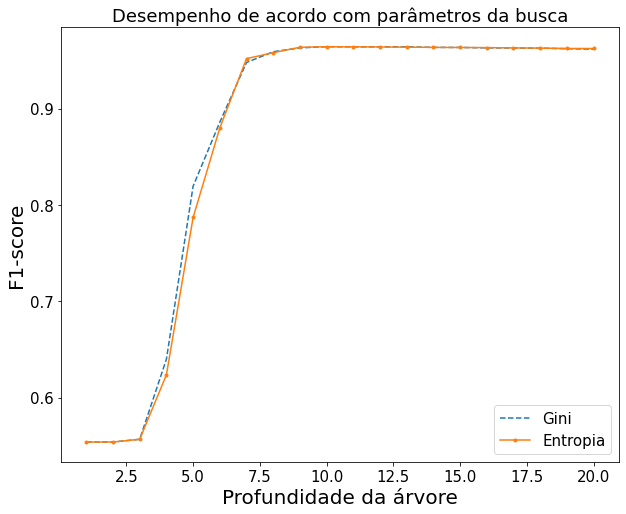

In [134]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 15})

plt.title('Desempenho de acordo com parâmetros da busca')
plt.ylabel('F1-score', fontsize=20)
plt.xlabel('Profundidade da árvore', fontsize=20)
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropia')
plt.legend(loc="lower right");

## Avaliação da importância das features

In [140]:
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, class_weight="balanced") # {0: 0.01, 1:0.99}

scores = cross_val_score(clf, X, y, cv=kf, scoring='f1') # recall

print("F1-Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1-Score: 0.958 (+/- 0.00)


In [141]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8)

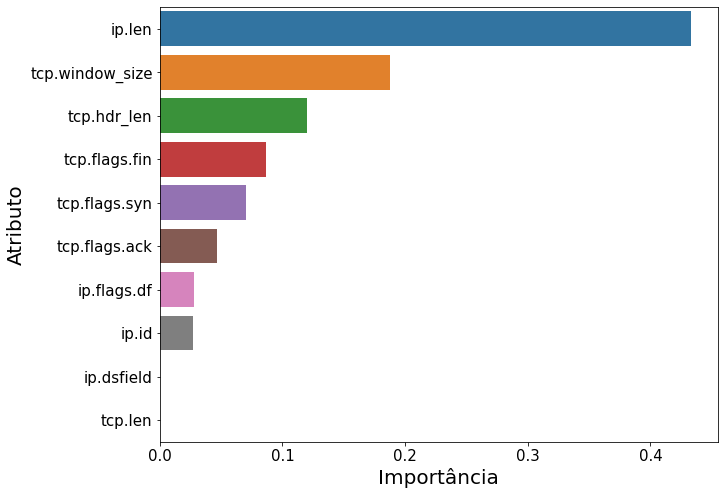

In [142]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(X.columns)

data = {'feature_name': feature_names,
       'feature_importance': feature_importance}

fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

relevantes = fi_df[fi_df.feature_importance > 0]

plt.figure(figsize=(10,8))
sns.barplot(x=relevantes['feature_importance'], y=relevantes['feature_name'])
plt.xlabel('Importância', fontsize=20)
plt.ylabel('Atributo', fontsize=20);

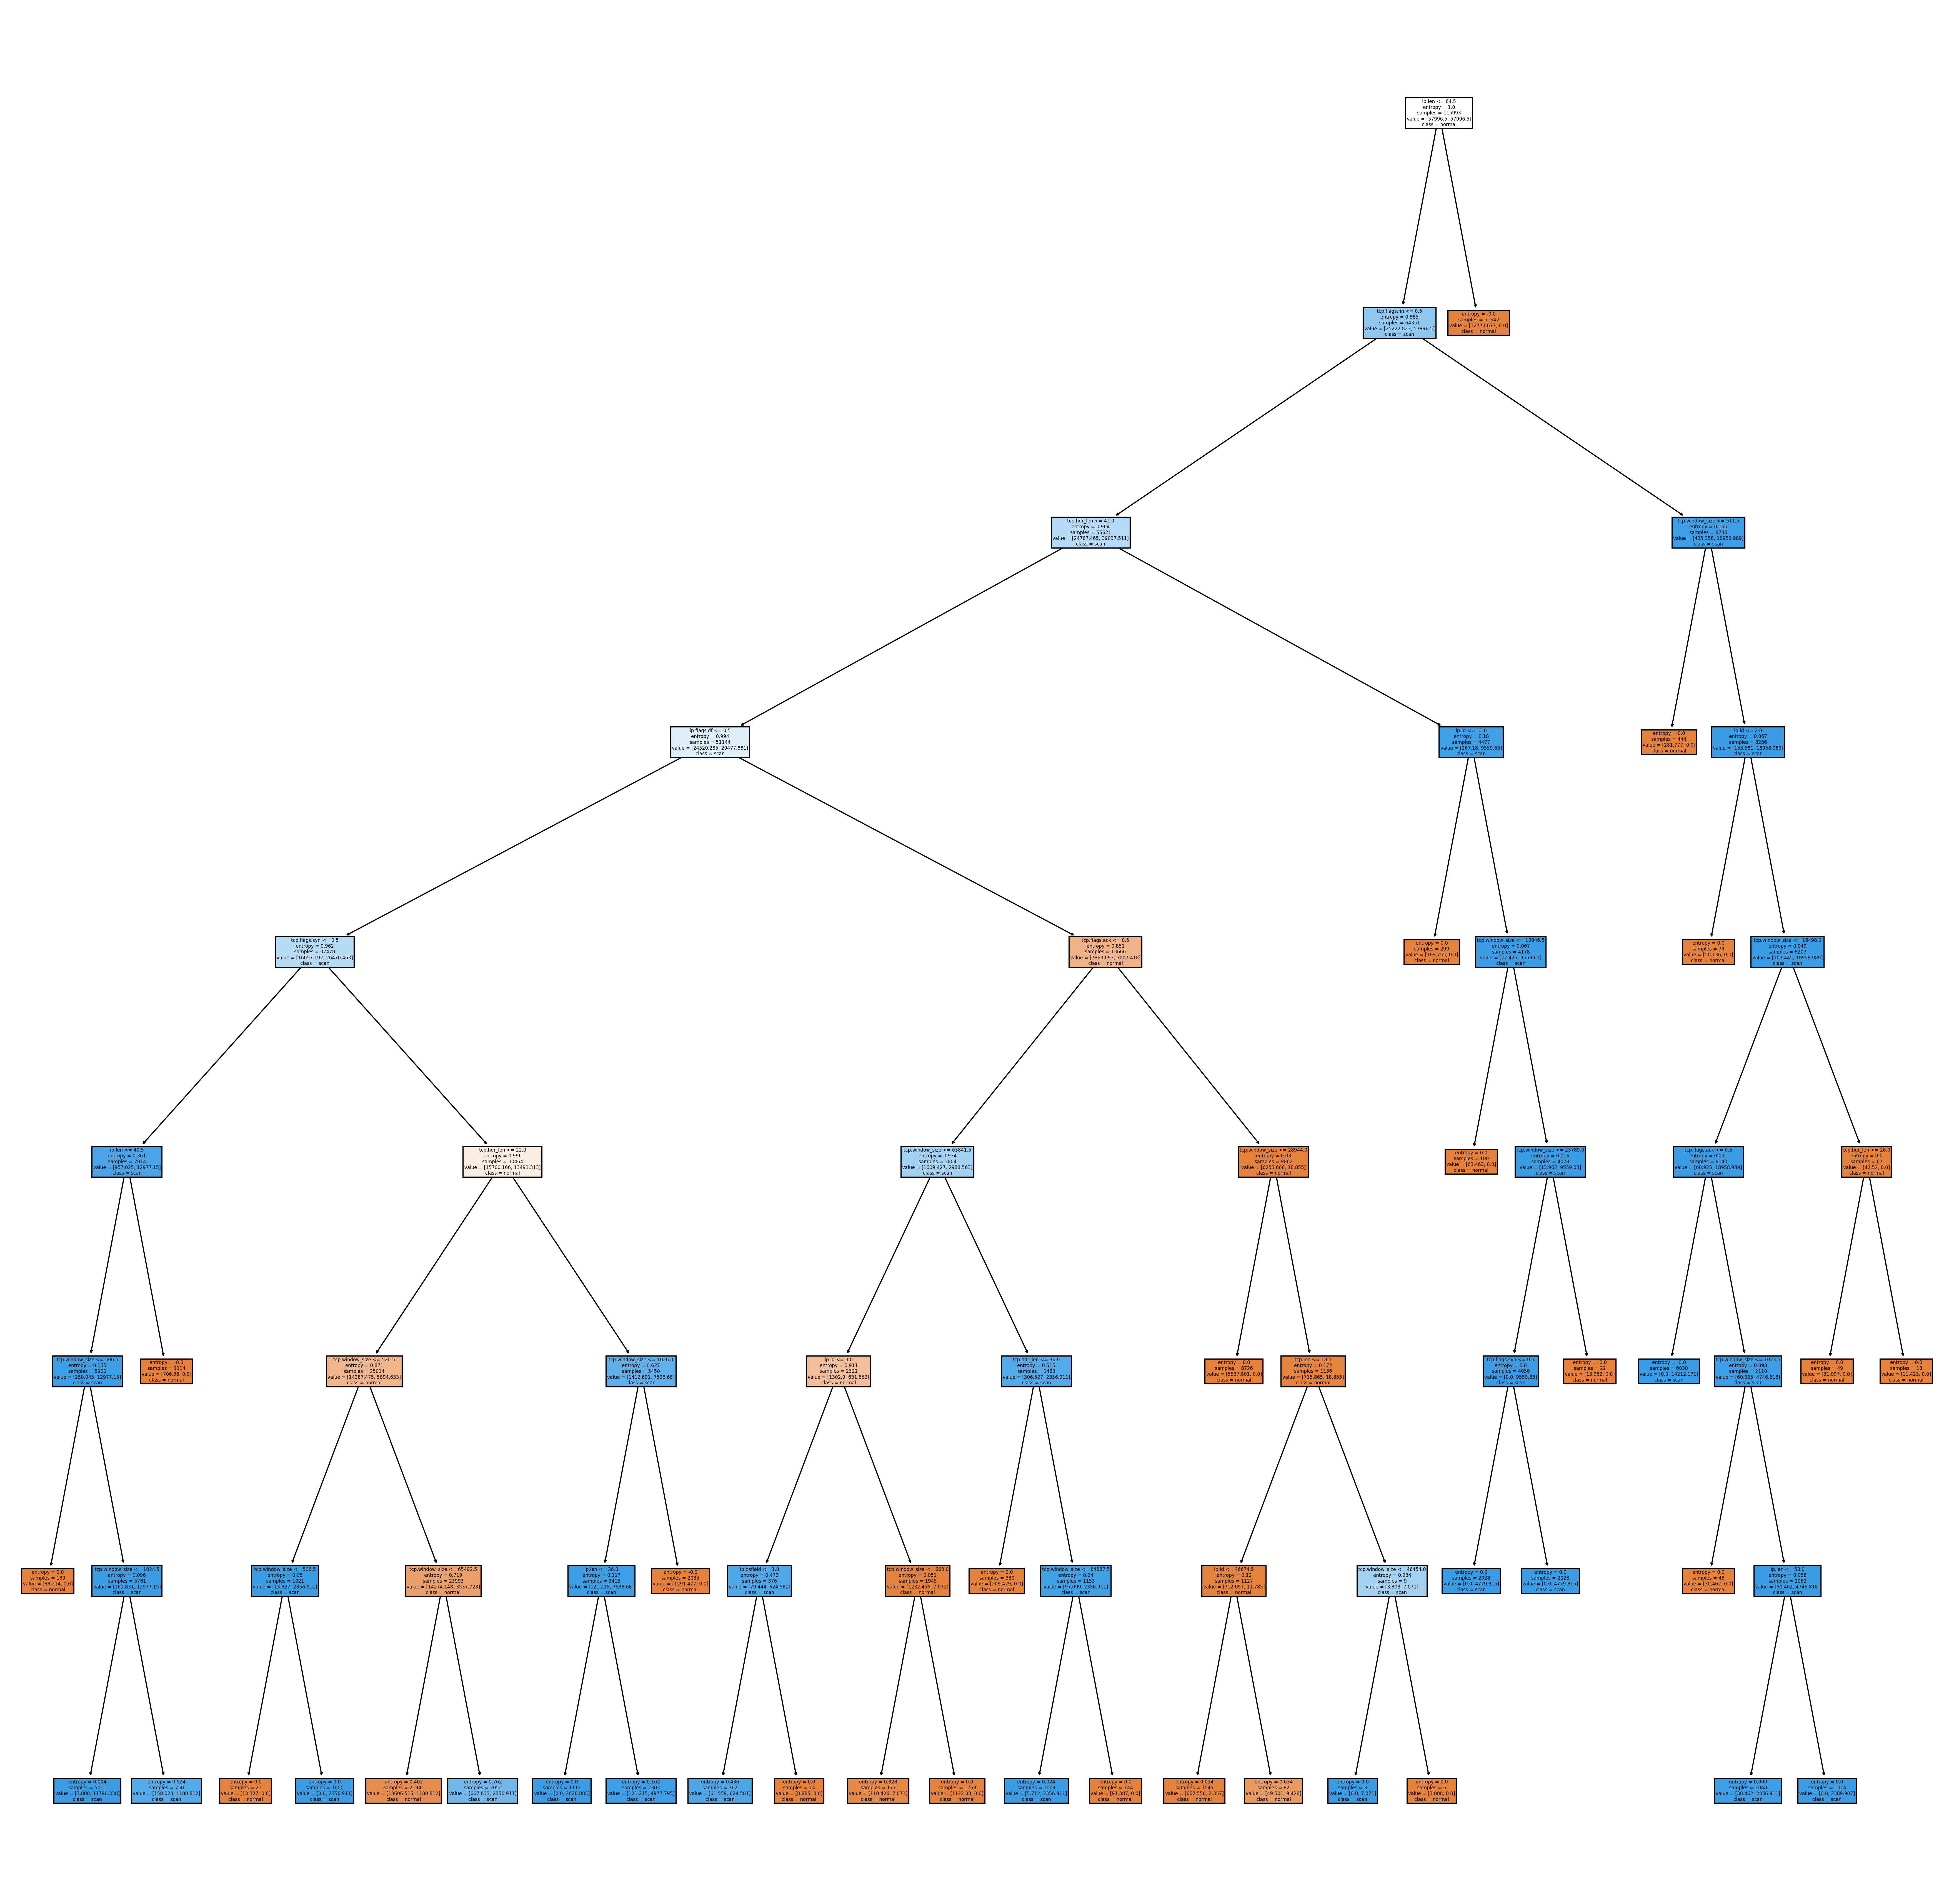

In [143]:
from sklearn import tree

fn=X.columns
cn=['normal', 'scan']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (30,30), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

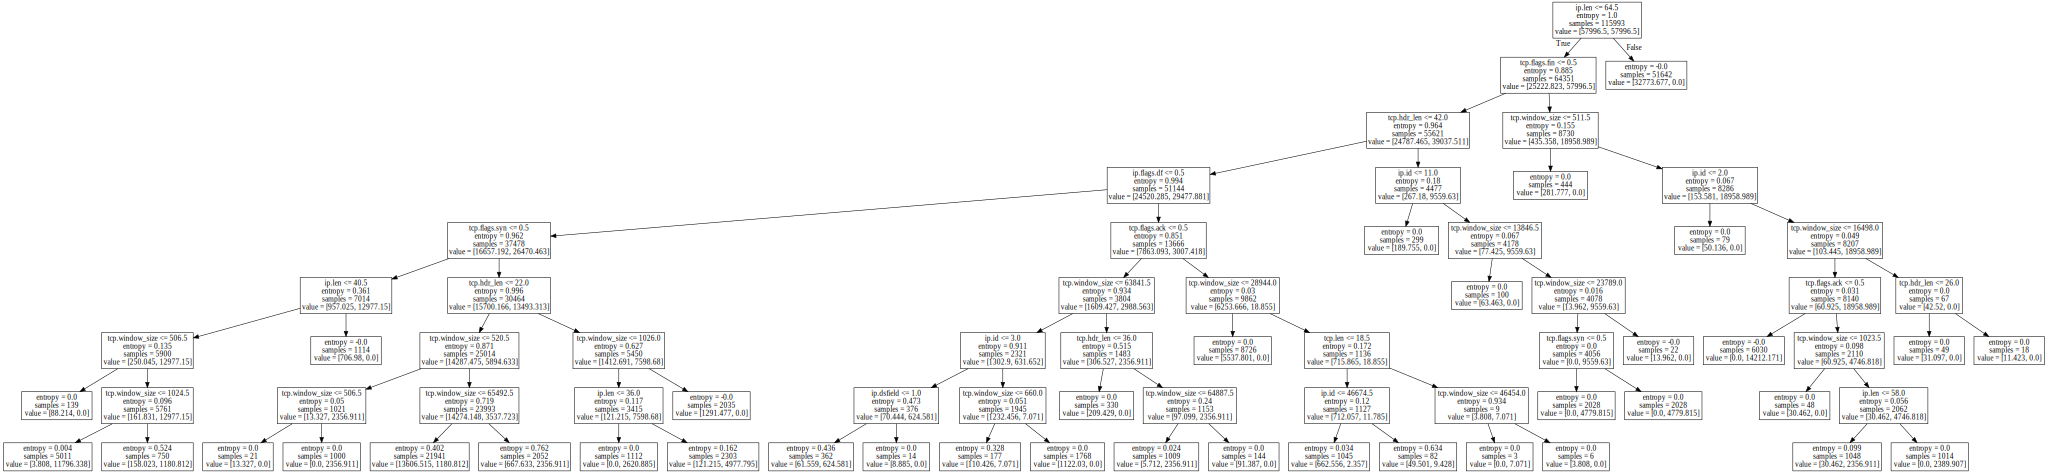

In [144]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(clf, out_file = None, feature_names=X.columns.tolist()))

# Geração do modelo de inferência para ser embarcado

In [145]:
import emlearn
cmodel = emlearn.convert(clf)
cmodel.save(file='./scan.h');

In [146]:
X.columns

Index(['ip.id', 'ip.flags.df', 'ip.len', 'ip.dsfield', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.urgent_pointer'],
      dtype='object')